In [1]:
#Python version 3.1 and causica version 3.2
# Posterior versions of causica dont have the ICGNN module

from dataclasses import dataclass

import numpy as np
import networkx as nx

import torch
import pytorch_lightning as pl

from torch.utils.data import DataLoader
from tensordict import TensorDict

from castle.datasets import DAG, IIDSimulation 
from castle.common import GraphDAG
from castle.metrics import MetricsDAG

import causica.distributions as cd

from causica.functional_relationships import *
from causica.training.auglag import AugLagLossCalculator, AugLagLR, AugLagLRConfig
from causica.graph.dag_constraint import calculate_dagness

from causica.datasets.variable_types import VariableTypeEnum
from causica.datasets.tensordict_utils import tensordict_shapes

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


from dowhy import gcm
import pandas as pd

/home/flav/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# Set random seed
SEED = 11
np.random.seed(SEED)
pl.seed_everything(SEED)  

Global seed set to 11


In [4]:
#Causal graph
causal_graph = nx.DiGraph([('d', 'messageReceived'),
                           ('d', 'graft'),
                           ('d', 'prune'),
                           ('d', 'iwant'),
                           ('dlo', 'graft'),
                           ('dhi', 'prune'),
                           ('dscore', 'graft'),
                           ('dscore', 'prune'),
                           ('dlazy', 'iwant'),
                           ('dlazy', 'ihave'),
                           ('dout', 'graft'),
                           ('dout', 'prune'),
                           ('gossipFactor', 'iwant'),
                           ('gossipFactor', 'ihave'),
                           ('interval', 'graft'),
                           ('interval', 'prune'),
                           ('interval', 'iwant'),
                           ('interval', 'ihave'),
                           ('topology', 'graft'),
                           ('topology', 'prune'),
                           ('topology', 'propagationTime'),
                           ('topology', 'messageReceived'),
                           ('prune', 'graft'),
                           ('prune', 'propagationTime'),
                           ('messageReceived', 'messageOverhead'),
                           ('messageOverhead', 'totalBandwidth'),
                           ('ihave', 'gossipBandwidth'),
                           ('iwant', 'gossipBandwidth'),
                           ('gossipBandwidth', 'totalBandwidth'),
                           ('messageReceived', 'messageBandwidth'),
                           ('messageBandwidth', 'totalBandwidth')
                         ])

In [5]:
#From digraph to adjancency matrix

# true_causal_matrix = nx.adjacency_matrix(causal_graph)
true_causal_matrix = nx.to_numpy_array(causal_graph)

print(true_causal_matrix)
print(causal_graph.nodes)

# adj_matrix=causal_graph

[[0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [6]:
#Treat dataset

#Import data 
# data = pd.read_csv('../datasets/consolidated.csv',header=0, index_col=0)
data = pd.read_csv('../GenerateDatasets/consolidated.csv',header=0, index_col=0)
consolidated = pd.DataFrame(data)

consolidated = consolidated.drop(columns=['experiment'])#, 'messageBandwidth'])#, 'gossipBandwidth'])#, 'messageDuplicated'])#, 'n_nodes', 'consensus', 'messageDuplicated'])
consolidated = consolidated.rename(columns={'topology':'top'})#, 'totalBandwidth':'bandwidth', 'gossipBandwidth':'rpcs'})
consolidated['topology'] = 0
consolidated.loc[consolidated['top'] == 'general', 'topology'] = 1
consolidated = consolidated.loc[consolidated['totalBandwidth'] > 0]
consolidated = consolidated.drop(columns=['top'])
# consolidated.head(100)

#Rearrange columns according to nodes list
nodes = causal_graph.nodes

X = consolidated[['d', 'messageReceived', 'graft', 'prune', 'iwant', 'dlo', 'dhi', 'dscore', 'dlazy', 'ihave', 'dout', 
                  'gossipFactor', 'interval', 'topology', 'propagationTime', 'messageOverhead', 'totalBandwidth', 'gossipBandwidth', 'messageBandwidth']].to_numpy()

# X = consolidated.to_numpy()
# print(X)
consolidated.head(10)

,propagationTime,messageOverhead,messageReceived,graft,prune,iwant,ihave,messageBandwidth,totalBandwidth,gossipBandwidth,d,dlo,dhi,dscore,dlazy,dout,gossipFactor,interval,topology
0,1856.745902,3748.0,520.0,0.0,0.0,0.0,0.0,521.0,8512.0,4243.0,8,6,12,4,8,2,0.25,1.0,0
1,1979.913793,478.0,59.0,0.0,0.0,0.0,347.0,59.0,1234.0,697.0,8,6,12,4,8,2,0.25,1.0,0
2,1670.648148,3986.0,542.0,0.0,0.0,0.0,0.0,547.0,9027.0,4494.0,8,6,12,4,8,2,0.25,1.0,0
3,1710.708333,472.0,72.0,0.0,0.0,0.0,351.0,72.0,1259.0,715.0,8,6,12,4,8,2,0.25,1.0,0
4,1879.665217,3703.0,503.0,0.0,0.0,0.0,0.0,505.0,8369.0,4161.0,8,6,12,4,8,2,0.25,1.0,0
5,1723.305556,538.0,73.0,0.0,0.0,0.0,347.0,73.0,1385.0,774.0,8,6,12,4,8,2,0.25,1.0,0
6,1816.257895,3430.0,465.0,0.0,0.0,0.0,0.0,465.0,7774.0,3879.0,8,6,12,4,8,2,0.25,1.0,0
7,1556.234783,786.0,115.0,0.0,0.0,0.0,342.0,115.0,1956.0,1055.0,8,6,12,4,8,2,0.25,1.0,0
8,2597.587302,3456.0,460.0,0.0,0.0,0.0,0.0,464.0,7833.0,3913.0,8,6,12,4,8,2,0.25,1.0,0
9,1654.754386,779.0,115.0,0.0,0.0,0.0,343.0,115.0,1947.0,1053.0,8,6,12,4,8,2,0.25,1.0,0


In [7]:
@dataclass(frozen=True)
class TrainingConfig:
 noise_dist=cd.ContinuousNoiseDist.SPLINE
 batch_size=512
 max_epoch=500
 gumbel_temp=0.25
 averaging_period=10
 prior_sparsity_lambda=5.0
 init_rho=1.0
 init_alpha=0.0
training_config = TrainingConfig()
auglag_config = AugLagLRConfig()

In [8]:
# Cast data to torch tensors
data_tensors = {}

for i in range(X.shape[1]):
    data_tensors[f'x{i}'] = torch.tensor(X[:, i].reshape(-1, 1))
    
dataset_train = TensorDict(data_tensors, torch.Size([X.shape[0]]))
    
# Move the entire dataset to the device (for big datasets move to device by batch within training loop)
dataset_train = dataset_train.apply(lambda t: t.to(dtype=torch.float32, device=device))

# Create loader
dataloader_train = DataLoader(
    dataset=dataset_train,
    collate_fn=lambda x: x,
    batch_size=training_config.batch_size,
    shuffle=True,
    drop_last=False,
)

dataset_train

TensorDict(
    fields={
        x0: Tensor(shape=torch.Size([163253, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x10: Tensor(shape=torch.Size([163253, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x11: Tensor(shape=torch.Size([163253, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x12: Tensor(shape=torch.Size([163253, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x13: Tensor(shape=torch.Size([163253, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x14: Tensor(shape=torch.Size([163253, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x15: Tensor(shape=torch.Size([163253, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x16: Tensor(shape=torch.Size([163253, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x17: Tensor(shape=torch.Size([163253, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x18: Tensor(shape=torch.Size([163253, 1]), device=

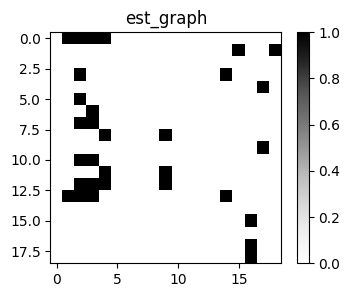

In [9]:
# Plot the true adj matrix
plt.style.use('default')
GraphDAG(true_causal_matrix)
plt.show()

In [10]:
# Encode our strong belief about the existence of the edge (3, 0) 
# And lack of existence of edge (0, 3)
adj_matrix = true_causal_matrix
expert_matrix = torch.tensor(np.zeros(adj_matrix.shape))

# Encode the edge knowledge
expert_matrix[3, 0] = 1.

# Create a relevancew mask
relevance_mask = expert_matrix.clone()
relevance_mask[0, 3] = 1.

# Create a confidence matrix
confidence_matrix = relevance_mask.clone()

In [11]:
# Encapsulate everything within the expert knowledge container
expert_knowledge = cd.ExpertGraphContainer(
    dag=expert_matrix,
    mask=relevance_mask,
    confidence=confidence_matrix,
    scale=5.
)

In [12]:
num_nodes = len(dataset_train.keys())

# Define the prior
prior = cd.GibbsDAGPrior(
    num_nodes=num_nodes, 
    sparsity_lambda=training_config.prior_sparsity_lambda,
    expert_graph_container=expert_knowledge
)

In [13]:
# Define the adjaceny module
adjacency_dist = cd.ENCOAdjacencyDistributionModule(num_nodes)

#Define the functional module
icgnn = ICGNN(
    variables=tensordict_shapes(dataset_train),
    embedding_size=8, #32,
    out_dim_g=8, #32,
    norm_layer=torch.nn.LayerNorm,
    res_connection=True,
)

# Define the noise module
types_dict = {var_name: VariableTypeEnum.CONTINUOUS for var_name in dataset_train.keys()}

noise_submodules = cd.create_noise_modules(
    shapes=tensordict_shapes(dataset_train), 
    types=types_dict, 
    continuous_noise_dist=training_config.noise_dist
)

noise_module = cd.JointNoiseModule(noise_submodules)

In [14]:
noise_submodules

{'x0': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x1': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x2': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x3': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x4': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x5': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x6': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x7': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x8': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
    

In [15]:
#Treat dataset

#Import data 
# data = pd.read_csv('../datasets/consolidated.csv',header=0, index_col=0)
data = pd.read_csv('../GenerateDatasets/consolidated.csv',header=0, index_col=0)
consolidated = pd.DataFrame(data)

consolidated = consolidated.drop(columns=['experiment'])#, 'messageDuplicated'])#, 'n_nodes', 'consensus', 'messageDuplicated'])
consolidated = consolidated.rename(columns={'topology':'top'})
consolidated['topology'] = 0
consolidated.loc[consolidated['top'] == 'general', 'topology'] = 1
consolidated = consolidated.drop(columns=['top'])
# consolidated.head(100)

#Rearrange columns according to nodes list
nodes = causal_graph.nodes

X = consolidated[['d', 'messageReceived', 'graft', 'prune', 'iwant', 'dlo', 'dhi', 'dscore', 'dlazy', 'ihave', 'dout', 'gossipFactor', 
                  'interval', 'topology', 'propagationTime', 'messageOverhead', 'messageBandwidth', 'totalBandwidth', 'gossipBandwidth']].to_numpy()

# X = consolidated.to_numpy()
print(X)

[[8.000e+00 5.200e+02 0.000e+00 ... 5.210e+02 8.512e+03 4.243e+03]
 [8.000e+00 5.900e+01 0.000e+00 ... 5.900e+01 1.234e+03 6.970e+02]
 [8.000e+00 5.420e+02 0.000e+00 ... 5.470e+02 9.027e+03 4.494e+03]
 ...
 [2.100e+01 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 1.420e+02]
 [2.100e+01 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 1.424e+03]
 [2.100e+01 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 1.430e+02]]


In [16]:
# Combine all SEM modules
sem_module = cd.SEMDistributionModule(
    adjacency_module=adjacency_dist, 
    functional_relationships=icgnn, 
    noise_module=noise_module)

sem_module.to(device)

SEMDistributionModule(
  (adjacency_module): ENCOAdjacencyDistributionModule()
  (functional_relationships): ICGNN(
    (nn): FGNNI(
      (g): Sequential(
        (0): Sequential(
          (0): Linear(in_features=27, out_features=76, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
        )
        (1): _ResBlock(
          (block): Sequential(
            (0): LayerNorm((76,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=76, out_features=76, bias=True)
            (2): LeakyReLU(negative_slope=0.01)
          )
        )
        (2): LayerNorm((76,), eps=1e-05, elementwise_affine=True)
        (3): Linear(in_features=76, out_features=8, bias=True)
        (4): Identity()
      )
      (f): Sequential(
        (0): Sequential(
          (0): Linear(in_features=16, out_features=76, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
        )
        (1): _ResBlock(
          (block): Sequential(
            (0): LayerNorm((76,), eps=1e-05, ele

In [17]:
modules = {
    "icgnn": sem_module.functional_relationships,
    "vardist": sem_module.adjacency_module,
    "noise_dist": sem_module.noise_module,
}

parameter_list = [
    {"params": module.parameters(), "lr": auglag_config.lr_init_dict[name], "name": name}
    for name, module in modules.items()
]

# Define the optimizer
optimizer = torch.optim.Adam(parameter_list)

In [18]:
# Define the augmented Lagrangian loss objects
scheduler = AugLagLR(config=auglag_config)

auglag_loss = AugLagLossCalculator(
    init_alpha=training_config.init_alpha, 
    init_rho=training_config.init_rho
)

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:0 loss:7.1587e+08 nll:7.1587e+08 dagness:67.32173 num_edges:82 alpha:0 rho:1 step:0|1 num_lr_updates:0


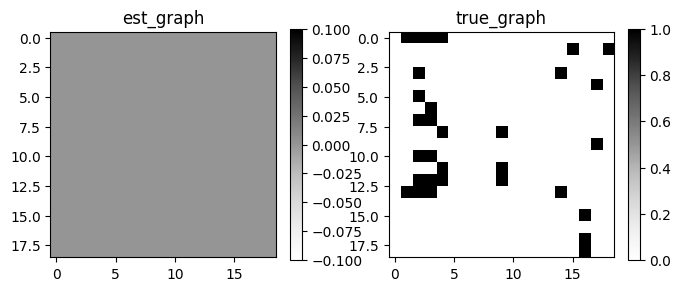

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Updating alpha to: 89.99323272705078
epoch:10 loss:1.4073e+05 nll:1.4073e+05 dagness:84.43484 num_edges:140 alpha:89.993 rho:1 step:1|191 num_lr_updates:0


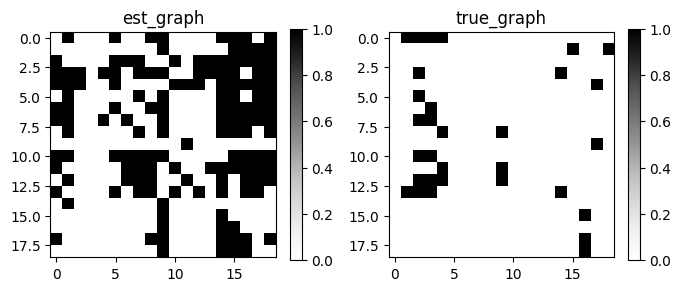

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Updating alpha to: 100.37445259094238
epoch:20 loss:17021 nll:17021 dagness:10.60929 num_edges:138 alpha:100.37 rho:1 step:2|381 num_lr_updates:0


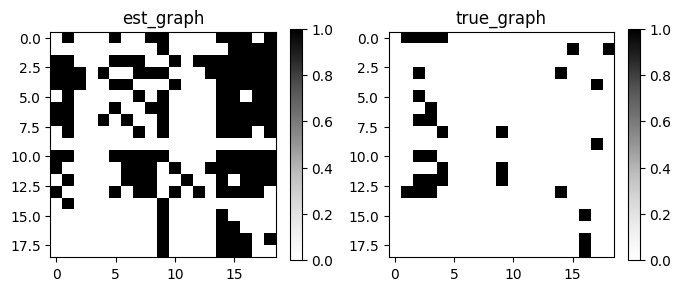

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Updating rho, dag penalty prev:  10.3812198639
epoch:30 loss:6162.1 nll:6162.1 dagness:9.72279 num_edges:139 alpha:100.37 rho:10 step:3|1476 num_lr_updates:0


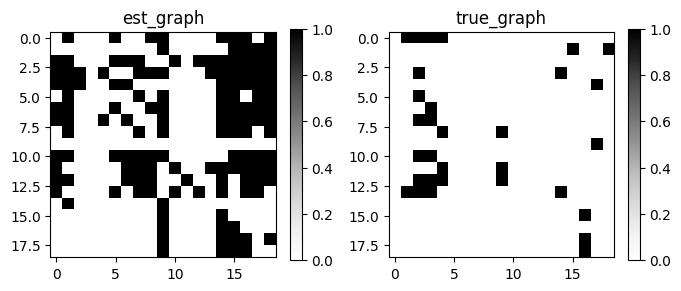

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Updating rho, dag penalty prev:  10.3812198639
Updating rho, dag penalty prev:  10.3812198639
epoch:40 loss:1374 nll:1374 dagness:8.31745 num_edges:138 alpha:100.37 rho:1000 step:5|186 num_lr_updates:0


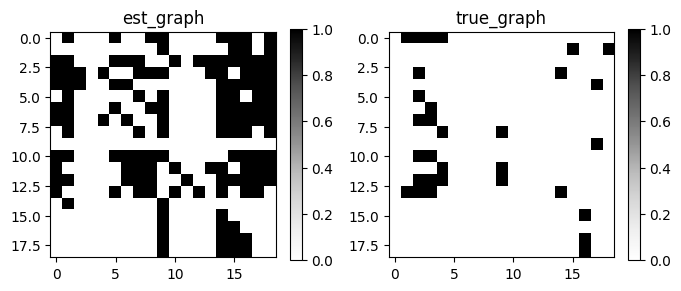

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Updating alpha to: 6805.713884353638
epoch:50 loss:1386.4 nll:1386.2 dagness:4.63144 num_edges:132 alpha:6805.7 rho:1000 step:6|376 num_lr_updates:0


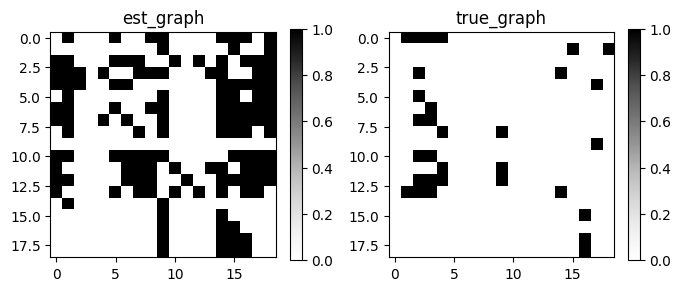

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Updating alpha to: 11126.945726394653
epoch:60 loss:92.59 nll:92.384 dagness:2.96629 num_edges:127 alpha:11127 rho:1000 step:7|2160 num_lr_updates:0


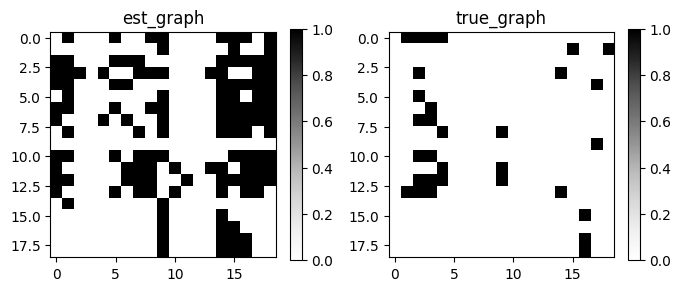

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Updating rho, dag penalty prev:  4.3212318420
Updating rho, dag penalty prev:  4.3212318420
epoch:70 loss:26530 nll:26530 dagness:2.96629 num_edges:126 alpha:11127 rho:1e+05 step:9|492 num_lr_updates:0


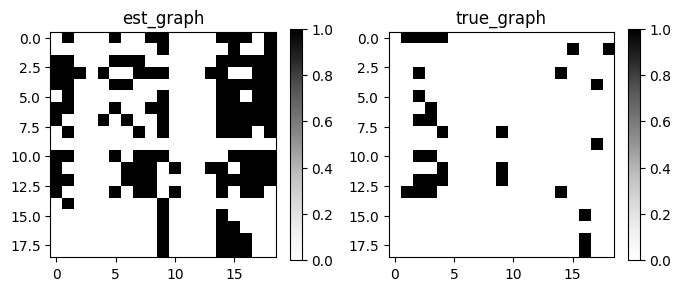

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Updating rho, dag penalty prev:  4.3212318420
epoch:80 loss:67.982 nll:67.776 dagness:2.96629 num_edges:129 alpha:11127 rho:1e+06 step:10|1294 num_lr_updates:0


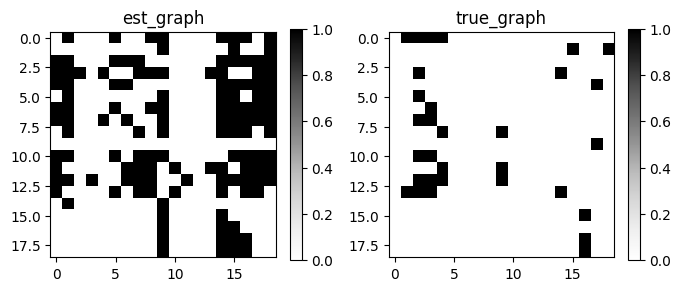

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Updating rho, dag penalty prev:  4.3212318420
epoch:90 loss:47.832 nll:47.624 dagness:2.96629 num_edges:128 alpha:11127 rho:1e+07 step:11|1647 num_lr_updates:1


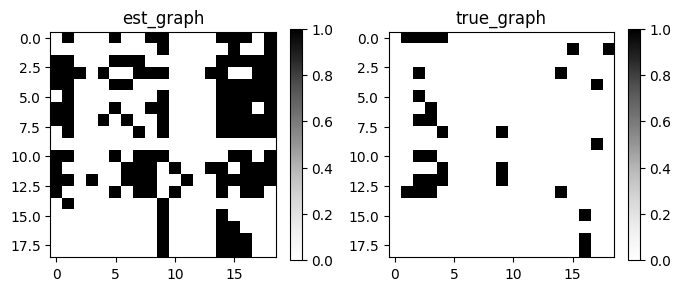

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Updating rho, dag penalty prev:  4.3212318420
Updating alpha to: 207242267.08244514
epoch:100 loss:2075.5 nll:2075.5 dagness:0.00000 num_edges:119 alpha:2.0724e+08 rho:1e+08 step:13|389 num_lr_updates:0


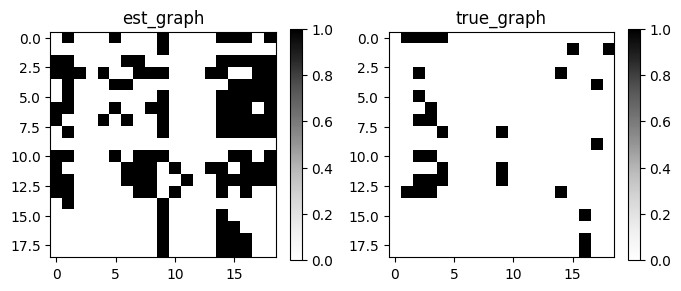

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Updating alpha to: 1036211335.4122257
epoch:110 loss:51.122 nll:51.118 dagness:0.00000 num_edges:118 alpha:1.0362e+09 rho:1e+08 step:14|1380 num_lr_updates:1


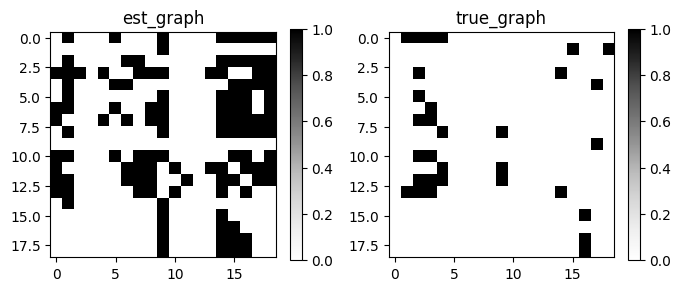

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Updating alpha to: 5181056677.061129
epoch:120 loss:49.437 nll:49.433 dagness:0.00000 num_edges:115 alpha:5.1811e+09 rho:1e+08 step:15|1570 num_lr_updates:1


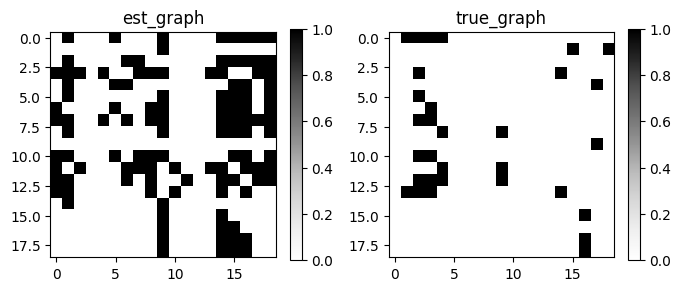

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Updating alpha to: 25905283385.30564
epoch:130 loss:49.856 nll:49.853 dagness:0.00000 num_edges:116 alpha:2.5905e+10 rho:1e+08 step:16|2580 num_lr_updates:2


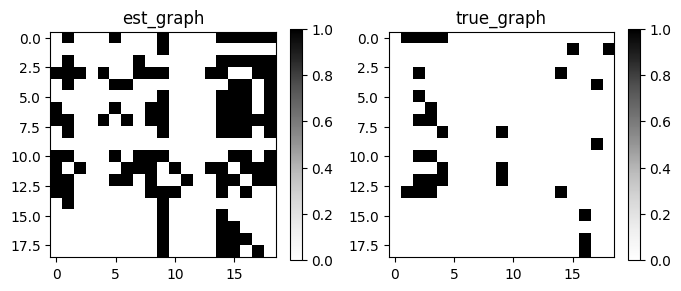

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Updating alpha to: 129526416926.5282
Updating alpha to: 647632084632.641
epoch:140 loss:56.387 nll:56.384 dagness:0.00000 num_edges:111 alpha:6.4763e+11 rho:1e+08 step:18|931 num_lr_updates:0


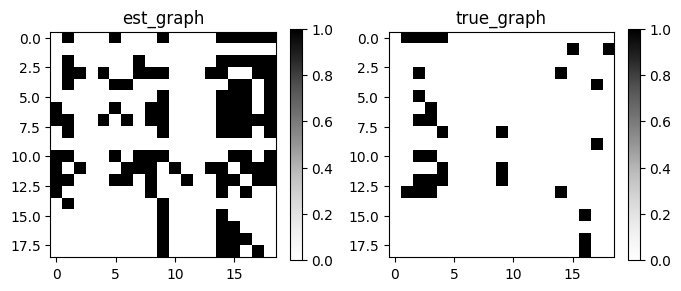

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:150 loss:53.624 nll:53.621 dagness:0.00000 num_edges:107 alpha:6.4763e+11 rho:1e+08 step:18|4121 num_lr_updates:1


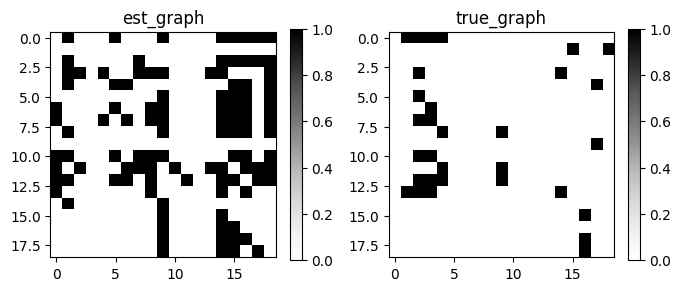

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:160 loss:48.032 nll:48.029 dagness:0.00000 num_edges:107 alpha:6.4763e+11 rho:1e+08 step:18|7311 num_lr_updates:1


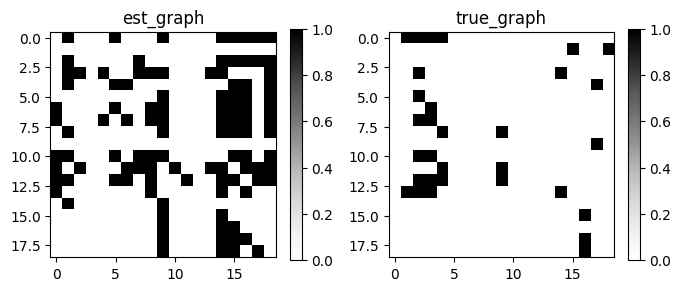

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:170 loss:52.302 nll:52.299 dagness:0.00000 num_edges:108 alpha:6.4763e+11 rho:1e+08 step:18|10501 num_lr_updates:1


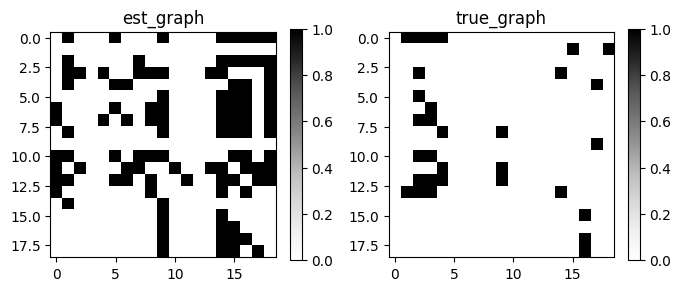

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:180 loss:49.003 nll:49 dagness:0.00000 num_edges:109 alpha:6.4763e+11 rho:1e+08 step:18|13691 num_lr_updates:1


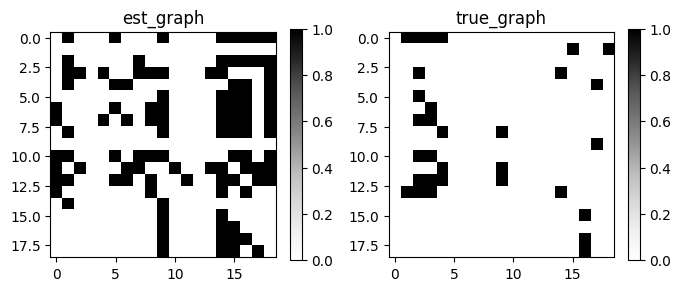

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


ValueError: Expected value argument (Tensor of shape (512, 1)) to be within the support (Real()) of the distribution Normal(loc: torch.Size([512, 1]), scale: torch.Size([512, 1])), but found invalid values:
tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]], grad_fn=<DivBackward0>)

In [19]:
assert len(dataset_train.batch_size) == 1, "Only 1D batch size is supported"

num_samples = len(dataset_train)

for epoch in range(training_config.max_epoch):
    
    for i, batch in enumerate(dataloader_train):
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Get SEM 
        sem_distribution = sem_module()
        sem, *_ = sem_distribution.relaxed_sample(
            torch.Size([]), 
            temperature=training_config.gumbel_temp
        )  # soft sample
        
        # Compute the log probability of data
        batch_log_prob = sem.log_prob(batch).mean()
        
        # Get the distribution entropy
        sem_distribution_entropy = sem_distribution.entropy()
        
        # Compute the likelihood of the current graph
        prior_term = prior.log_prob(sem.graph)
        
        # Compute the objective
        objective = (-sem_distribution_entropy - prior_term) / num_samples - batch_log_prob
        
        # Compute the DAG-ness term
        constraint = calculate_dagness(sem.graph)
        
        # Compute the Lagrangian loss
        loss = auglag_loss(objective, constraint / num_samples)

        # Propagate gradients and update
        loss.backward()
        optimizer.step()
        
        # Update the Auglag parameters
        scheduler.step(
            optimizer=optimizer,
            loss=auglag_loss,
            loss_value=loss.item(),
            lagrangian_penalty=constraint.item(),
        )
        
        # Log metrics & plot the matrices
        if epoch % 10 == 0 and i == 0:
            print(
                f"epoch:{epoch} loss:{loss.item():.5g} nll:{-batch_log_prob.detach().cpu().numpy():.5g} "
                f"dagness:{constraint.item():.5f} num_edges:{(sem.graph > 0.0).sum()} "
                f"alpha:{auglag_loss.alpha:.5g} rho:{auglag_loss.rho:.5g} "
                f"step:{scheduler.outer_opt_counter}|{scheduler.step_counter} "
                f"num_lr_updates:{scheduler.num_lr_updates}"
            )
            
            vardist = adjacency_dist()
            pred_dag = vardist.mode.cpu().numpy()

            plt.style.use('default')

            GraphDAG(
                est_dag=pred_dag, 
                true_dag=adj_matrix)

            plt.show()

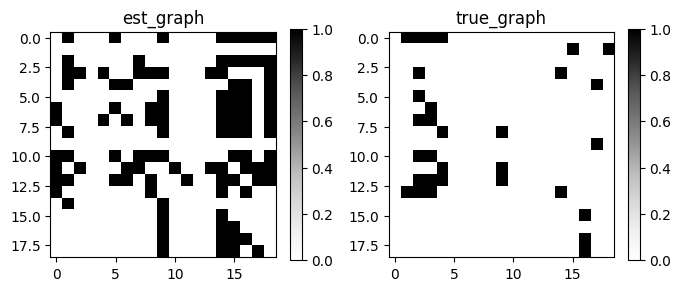

In [20]:
# Sample from the distribution of graphs
vardist = adjacency_dist()
pred_dag = vardist.mode.cpu().numpy()


# Plot the final graph vs the ground truth
plt.style.use('default')

GraphDAG(
    est_dag=pred_dag, 
    true_dag=adj_matrix)

plt.show()

In [21]:
# Compute and print the metrics
metrics = MetricsDAG(
    B_est=pred_dag, 
    B_true=adj_matrix)

metrics.metrics

{'fdr': 0.9434,
 'tpr': 0.1935,
 'fpr': 0.7143,
 'shd': 120,
 'nnz': 106,
 'precision': 0.0566,
 'recall': 0.1935,
 'F1': 0.0876,
 'gscore': 0.0}

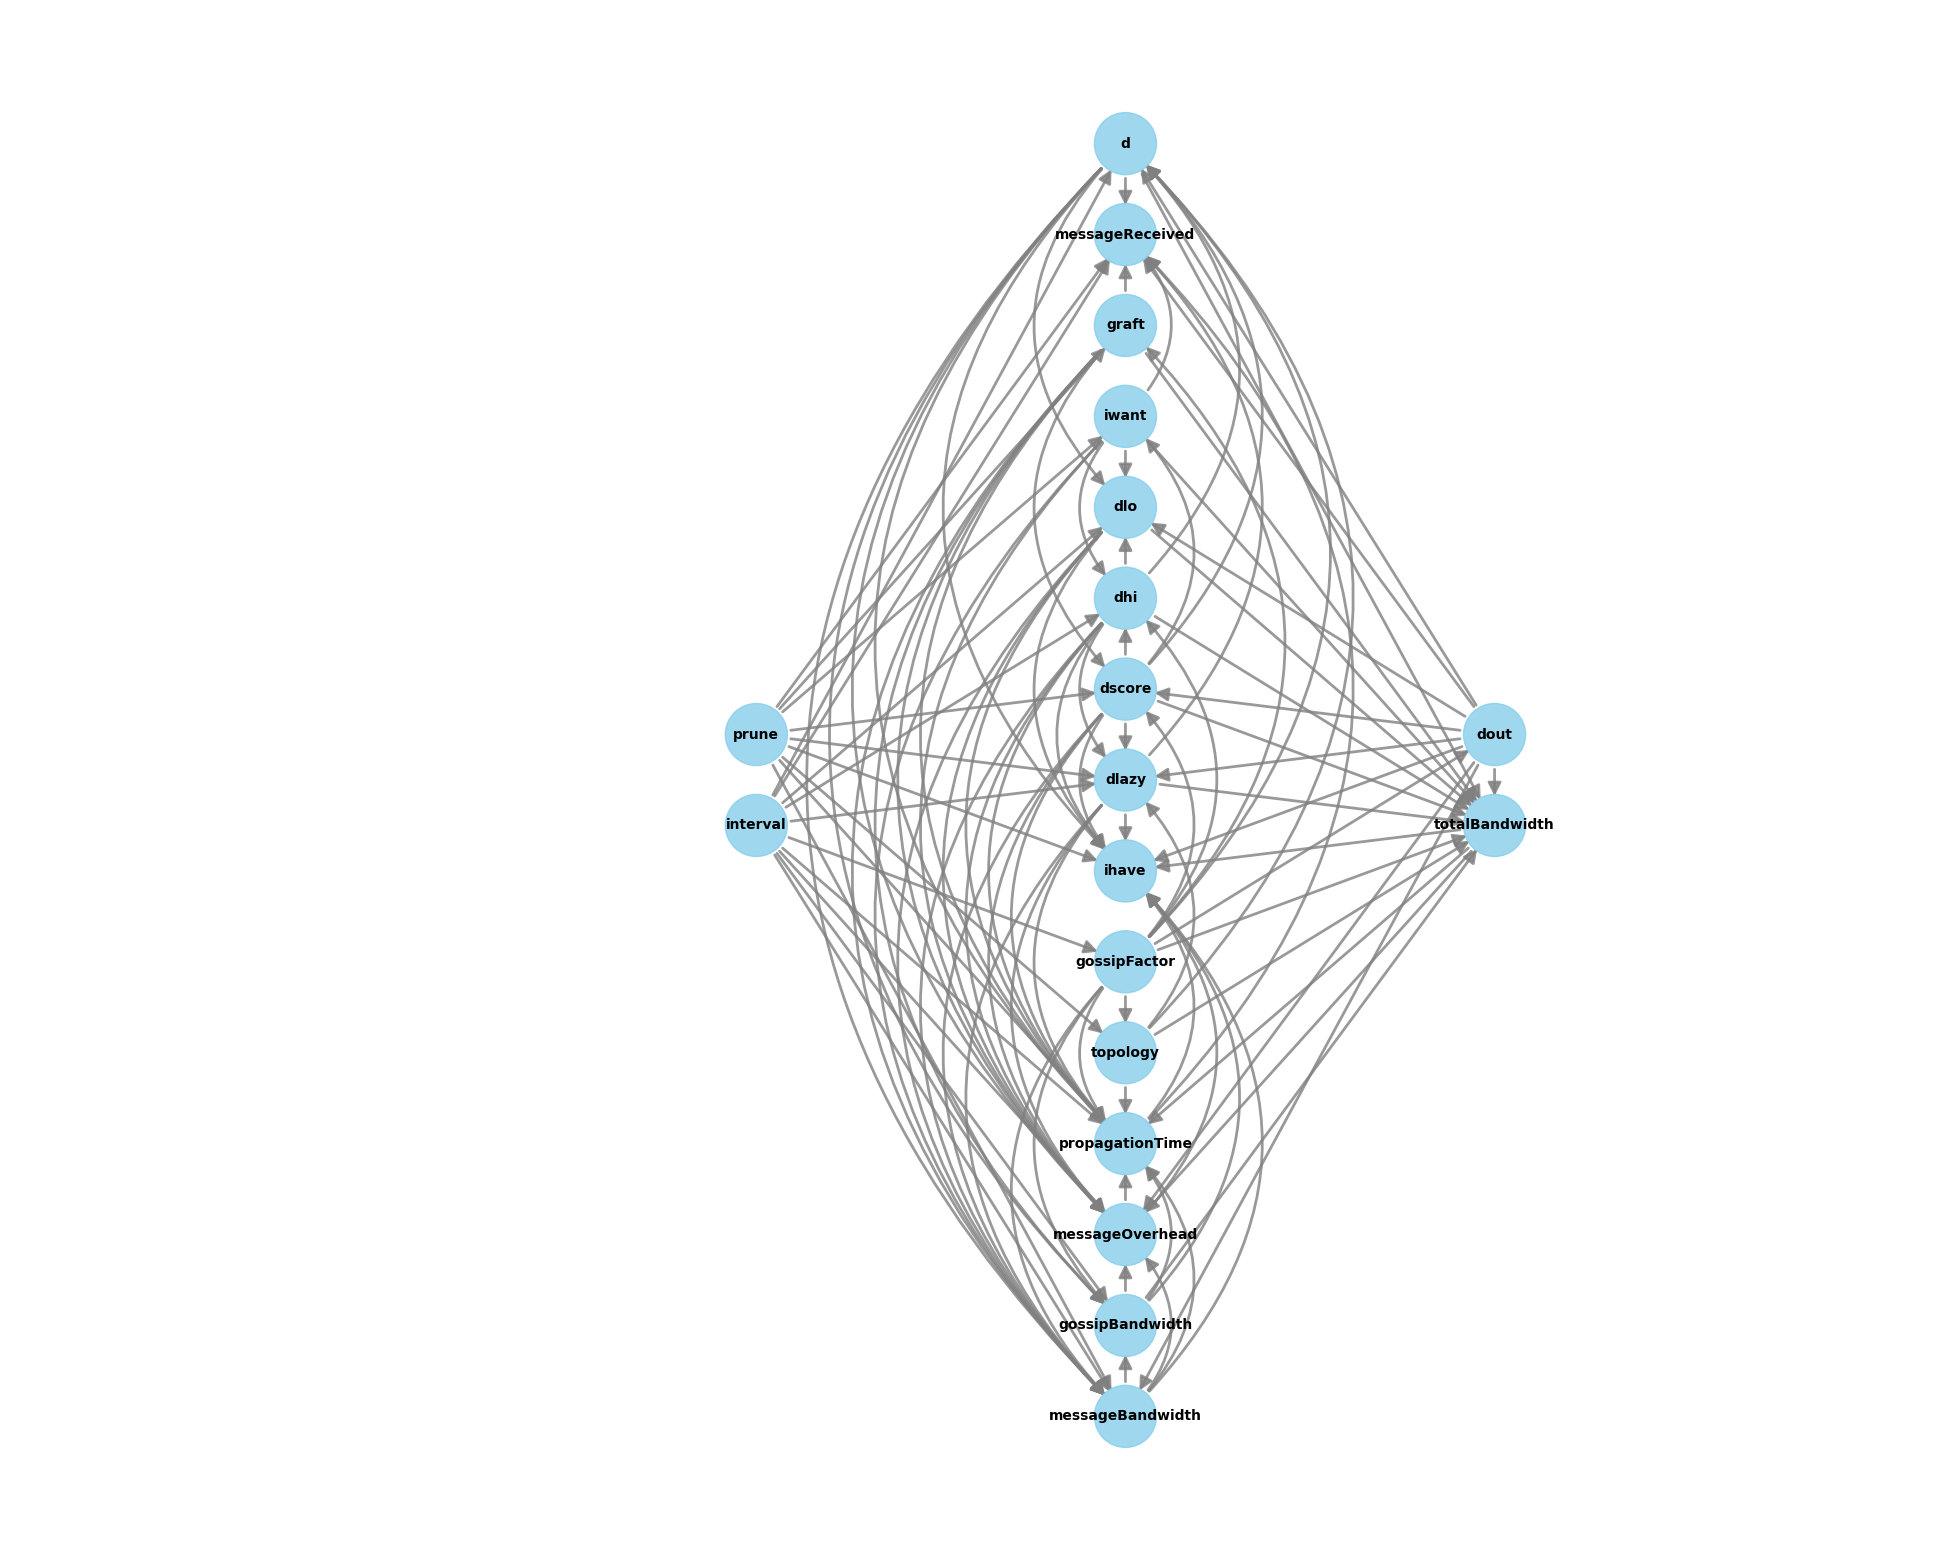

In [23]:
learned_causal_graph =  nx.from_numpy_array(pred_dag, create_using=nx.DiGraph)

mapping = {0:'d',
            1:'messageReceived',
            2:'graft',
            3:'prune',
            4:'iwant',
            5:'dlo',
            6:'dhi',
            7:'dscore',
            8:'dlazy',
            9:'ihave',
            10:'dout',
            11:'gossipFactor',
            12:'interval',
            13:'topology',
            14:'propagationTime',
            15:'messageOverhead',
            16:'totalBandwidth',
            17:'gossipBandwidth',
            18:'messageBandwidth'}

H = nx.relabel_nodes(learned_causal_graph, mapping)

nx.write_adjlist(H, "deci.adjlist")

# fig, ax = plt.subplots(figsize=(15,20)) 
gcm.util.plot(H, figure_size=[25, 20])